In [76]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report


penguins = load_penguins()
penguins.head()

#remove NA's from penguins dataset
penguins = penguins.dropna()

In [77]:
#want pipeline to predict genfoo species

#make gentoo column for penguins dataset

#true/falses is okay for modeling, multiply by 1 to make integers
penguins['is_gentoo'] = (penguins['species'] == 'Gentoo') * 1


Use the other variables in the dataset and a logistic regression model to classify penguins as either “Gentoo” or “Not”. What is your training accuracy?

In [78]:
#pipeline


#Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

#X = penguins.drop(["is_gentoo", "species"], axis = 1)
X = penguins[["bill_depth_mm", "sex"]]
y = penguins["is_gentoo"]


ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_logistic = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
).set_output(transform="pandas")

In [79]:
#Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

#score how well the model did
#R^2
scores = cross_val_score(lr_pipeline_logistic, X, y, cv=5, scoring='r2')
r2 = scores.mean()

#MSE
scores = cross_val_score(lr_pipeline_logistic, X, y, cv=5, scoring='accuracy')
accuracy = scores.mean()

print("r2: ", r2, " accuracy: ", accuracy)

r2:  0.9336282440175261  accuracy:  0.9848937132519222
r2:  0.9336282440175261  accuracy:  0.9848937132519222


Let's use the other variables to predict species. Prepare your data and fit the following models on the entire dataset:

- Two kNN models (for different values of K)
- Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

- Confusion matrix
- Overall Accuracy
- Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [80]:
ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

In [81]:
#kNN model pipeline
#k=3
knn3_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsClassifier(n_neighbors=3))
])
#k=5
knn5_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

#decision tree pipeline
#low complexity with max_depth = 3
dt_pipeline_low_complex = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(max_depth = 3))
])

#high complexity with max_depth = 15
dt_pipeline_high_complex = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(max_depth = 15))
])

In [82]:
#variable selection
#X = penguins.drop(["is_gentoo", "species"], axis = 1)
X = penguins[["bill_depth_mm", "sex"]]
y = penguins["is_gentoo"]

#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



**Precision, Recall, AUC, and F1-score for each species**

In [87]:
# List of pipelines
pipelines = {
    "kNN (k=3)": knn3_pipeline,
    "kNN (k=5)": knn5_pipeline,
    "Decision Tree (low complexity)": dt_pipeline_low_complex,
    "Decision Tree (high complexity)": dt_pipeline_high_complex
}

# Initialize results dictionary
results = []

# Loop through pipelines and calculate metrics
for name, pipeline in pipelines.items():
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predictions and probabilities
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps["decision_tree"] if "decision_tree" in pipeline.named_steps else pipeline.named_steps["knn"], "predict_proba") else None
    
    # Metrics
    accuracy = scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    accuracy = scores.mean()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Append results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc_score
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,kNN (k=3),0.978878,0.941176,0.888889,0.914286,0.987528
1,kNN (k=5),0.981909,0.941176,0.888889,0.914286,0.996599
2,Decision Tree (low complexity),0.981954,0.888889,0.888889,0.888889,0.933107
3,Decision Tree (high complexity),0.990909,0.941176,0.888889,0.914286,0.933107


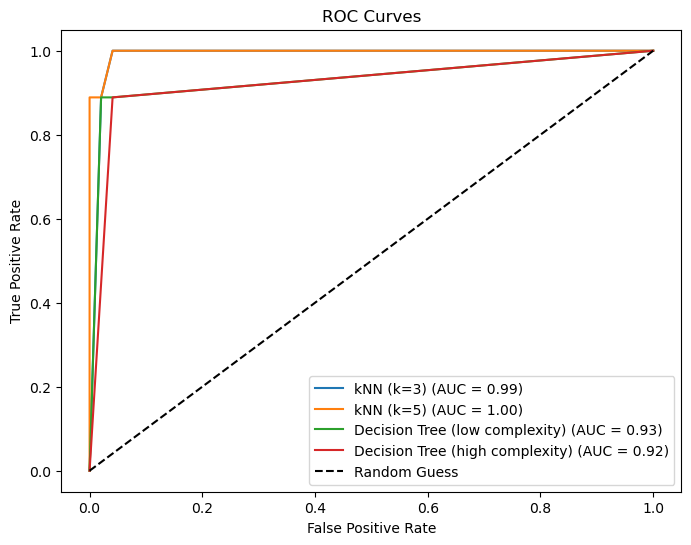

In [85]:
# Optional: Plot ROC curves for all pipelines

#copied from CHAT GPT to make it fit all of them, but to just fit one the code is below
plt.figure(figsize=(8, 6))
for name, pipeline in pipelines.items():
    if hasattr(pipeline.named_steps["decision_tree"] if "decision_tree" in pipeline.named_steps else pipeline.named_steps["knn"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

**ROC PLOT**

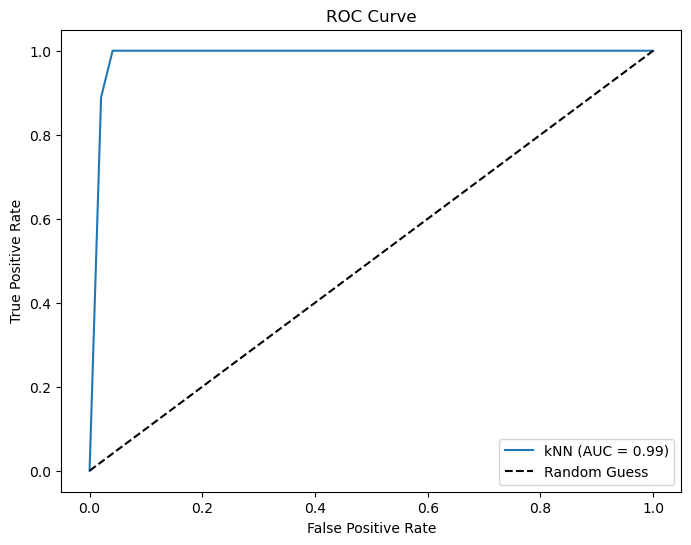

In [86]:
# Fit and predict probabilities
knn3_pipeline.fit(X_train, y_train)
y_pred_proba = knn3_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'kNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


When fitting every variable we get perfect prediction, we can see that even just using bill_length and sex gives all methods a close to perfect prediction.

With the variables selected, the best method overall appears to be Knn=5 from the options used.